In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [3]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
res = {}
for i in [1.]:
    tic = time.perf_counter()
    tgl = InequalityTimeGraphicalLasso(max_iter=500, loss='LL', c_level=0.25, c_prox='cvx', rho=1e2, div=i, tol=1e-8, rtol=1e-8, psi="laplacian")
    res[i] = tgl.fit_cov(X_cov).eval_cov_pre() 
    toc = time.perf_counter()
    print('Running Time :{}'.format(toc - tic))

26 818.9537043114674
1.9781010721747785e-08 3.4191615877621614e-06
2.874888026176642e-06 2.905467564467142e-06
Running Time :12.694560117000002


In [44]:
from regain.covariance import TaylorProxTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = TaylorProxTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.25, rho=1e2, theta=0.5, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))
print(min_pre_tp)

-6.1854624378519425
-6.083634249675425
-5.895636305786813
-5.588195968541976
-5.127969281392844
-4.49266355948686
-3.6762069744713894
-2.690017324918262
-1.558671643990659
-0.3156359426003601
0.9970584951780086
2.333932921175501
3.644916136822356
4.886243173552792
6.016847629480396
6.999646256187369
7.807419346044309
8.416087858707309
8.813738748534554
8.997775432031217
8.96865728320344
8.73644286649822
8.316600604606045
7.734760736810549
7.0279023409460475
6.233837050601201
5.359880245218803
4.424203425218244
3.4654759474974886
2.517800049515601
1.6254793796513765
0.8049414061675995
0.06571842643543142
-0.59574445220339
-1.1763608979391968
-1.6733209423498687
-2.086491415109367
-2.420470689202947
-2.6825410785322577
-2.8816330003083657
-3.026626300477184
-3.126459675753301
-3.1896994891478516
-3.2236194452076194
-3.233695626036879
-3.2239106142255824
-3.1969800866662577
-3.1545555817654365
-3.097600595645598
-3.0268560017881008
-2.9422589460490394
-2.843948923687077
-2.731823330517171

0.009310123181756396
0.009378537881799289
0.009444249301163977
0.009509604835365124
0.009574304614426196
0.009637304521813519
0.009700536605377508
0.009762677970417428
0.00982194842663297
0.009881640515692212
0.00994191345842104
0.010000496461699128
0.010057935037468085
0.010114671033905936
0.010170285153792733
0.01022600271143837
0.01028246781497451
0.010338117389864294
0.010387815230569758
0.010437132963780158
0.010486608960388537
0.010536508806558018
0.01058715057712277
0.010638827899992763
0.010691627640605503
0.010745521620292351
0.010800601240524515
0.010855345904873985
0.010906043564240662
0.010951076069623368
0.010995297125178922
0.011040558560794125
0.011087164989356281
0.01113523102562965
0.01118304416267975
0.011228654686988975
0.011275002218252013
0.011322339195580754
0.011370830337525036
0.011418379815428495
0.011464629348654895
0.011510625903961725
0.011554430372844635
0.011594994833568819
0.011636514151196663
0.011678857145954992
0.011722125287708352
0.011763771817550577

0.003047159673993747
0.0030277102883894715
0.0030085101729704178
0.0029895623020833994
0.002970867060830571
0.0029524254319977673
0.002934238771494577
0.002916306842497747
0.0028986270198809194
0.002881196901569467
0.0028640160375565673
0.002847082008263797
0.0028303885602602463
0.002813932133183883
0.00279771125586862
0.0027817090799317156
0.002765918190259313
0.0027503379319530554
0.0027349675424731146
0.0027198056544479954
0.002704850392451874
0.0026900994535725433
0.002675550167507481
0.002661199550808604
0.002647044347417733
0.0026330810674945583
0.002619306016563954
0.0026057153250768294
0.0025923049707336078
0.0025790708022520193
0.002566008557440398
0.0025531138831146193
0.0025403823503624776
0.002527809471724254
0.0025153853143654458
0.002503101694461094
0.0024909523190152784
0.0024789314435106034
0.0024670347689431083
0.002455258099135662
0.002443597313819268
0.002432048358841712
0.002420604382553435
0.002409259636663634
0.0023980084117344092
0.002386847512603865
0.0023757737

/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/taylor_prox_time_graphical_lasso.py:259: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [26]:
np.sum([sum(sum(abs(pre_tp[t]) == 0)) for t in range(X_cov.shape[-1])])

31038

In [42]:
np.sum([sum(sum(abs(pre_tp[t]) < 1e-4)) for t in range(X_cov.shape[-1])])

31074

In [7]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = InequalityTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.25, c_prox='grad', rho=1e2, theta=0.5, psi="laplacian")
emp_inv_score_grad, baseline_score_grad, fit_score_grad, pre_grad = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


obj break
522 139.30239678802428
0.0009928675429166903 0.031203034398341573
0.07041363975122479 0.02851335170874136
Running Time :96.595213505


In [8]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol.npy")

In [33]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return sum(map(l1_od_norm, Z_0)) + sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [min_pre_tp]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][:1], psi))

453.71174212443344


In [34]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

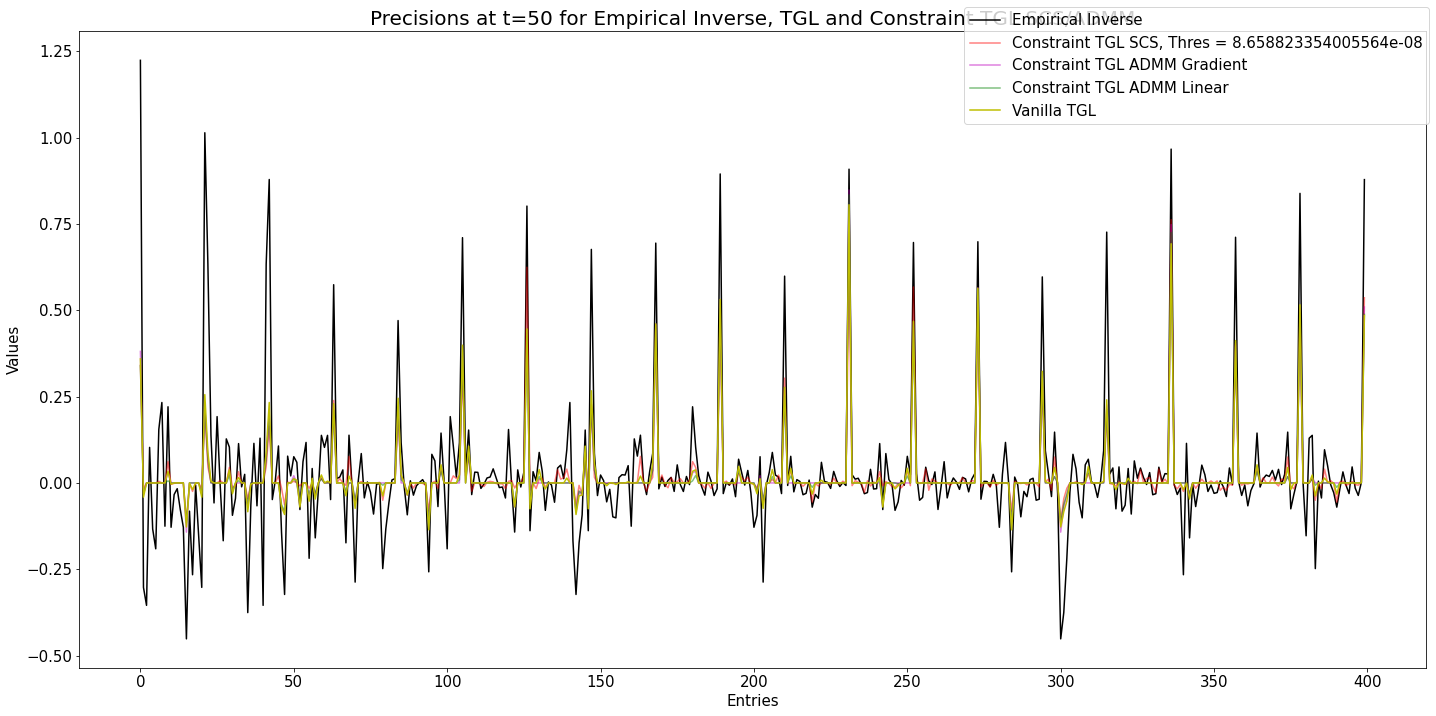

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

idx = 50

ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), tgl.emp_inv[idx].flatten(), color='k', label=r'Empirical Inverse')
for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre[i][idx].flatten(), color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), res[i][3][idx].flatten(), color='g', alpha=0.5,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_grad[idx].flatten(), color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient')
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_tp[idx].flatten(), color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear')
ax.plot(range(X_cov.shape[0] * X_cov.shape[0]), pre_[idx].flatten(), color='y', label=r'Vanilla TGL')


fig.legend(fontsize=15)
ax.set_ylabel('Values', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Entries', fontsize=15)
ax.set_title(r'Precisions at t={} for Empirical Inverse, TGL and Constraint TGL SCS/ADMM'.format(idx), fontsize=20)
plt.tight_layout()
plt.savefig('pre_{}_{}_{}_admm_relax_taylor.pdf'.format(idx, dim_X, dim_fac))

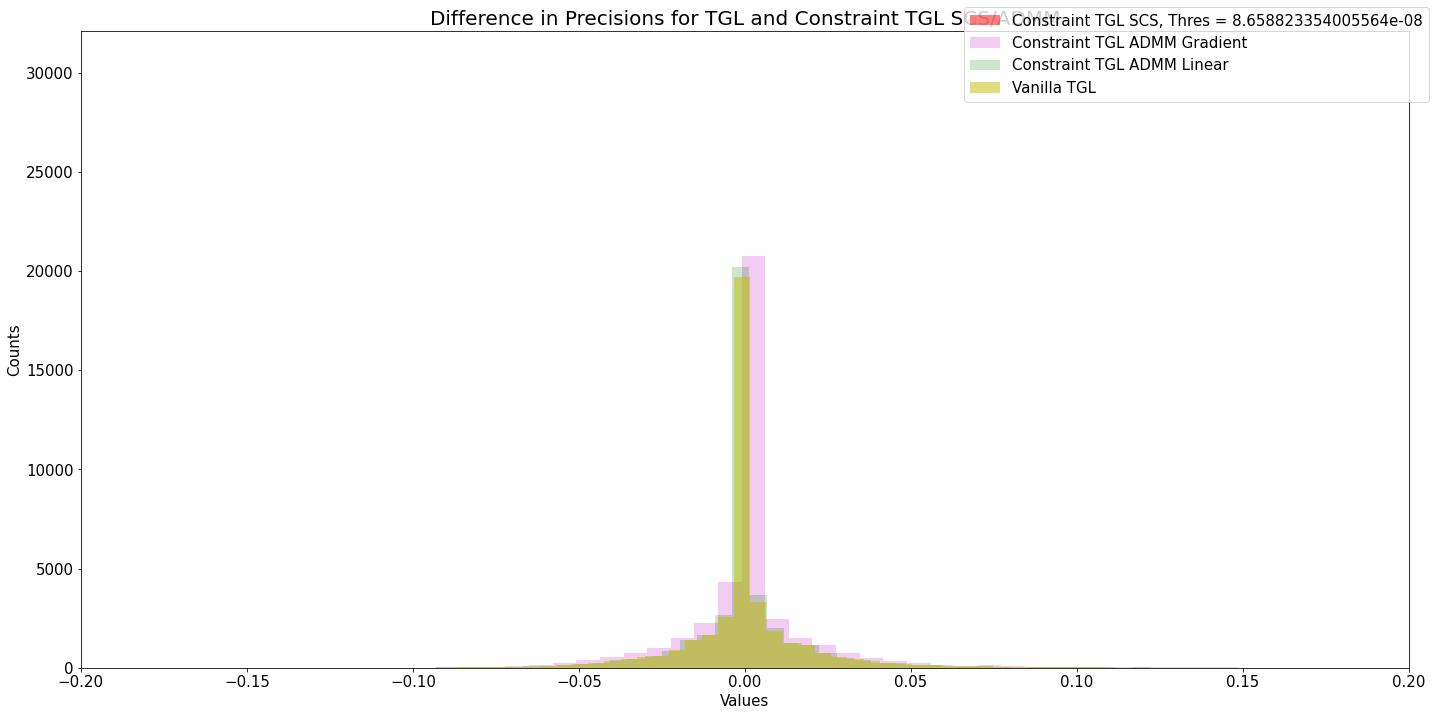

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    diff = (pre[i] -  pre_cvx).flatten()
    ax.hist(diff, bins=100, color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     diff = (res[i][3] -  pre_cvx).flatten()
#     ax.hist(diff, bins=50, color='g', alpha=0.2,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
diff = (pre_grad -  pre_cvx).flatten()
ax.hist(diff, bins=100, color='m', alpha=0.2,
        label=r'Constraint TGL ADMM Gradient')
diff = (pre_tp -  pre_cvx).flatten()
ax.hist(diff, bins=100, color='g', alpha=0.2,
        label=r'Constraint TGL ADMM Linear')
diff = (pre_ -  pre_cvx).flatten()
ax.hist(diff, bins=100, color='y', alpha=0.5, 
        label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Values', fontsize=15)
major_loc = MultipleLocator(base=0.05)
ax.xaxis.set_major_locator(major_loc)
ax.set_xlim((-0.2, 0.2))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(r'Difference in Precisions for TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('pre_diff_hist_{}_{}_taylor.pdf'.format(dim_X, dim_fac))

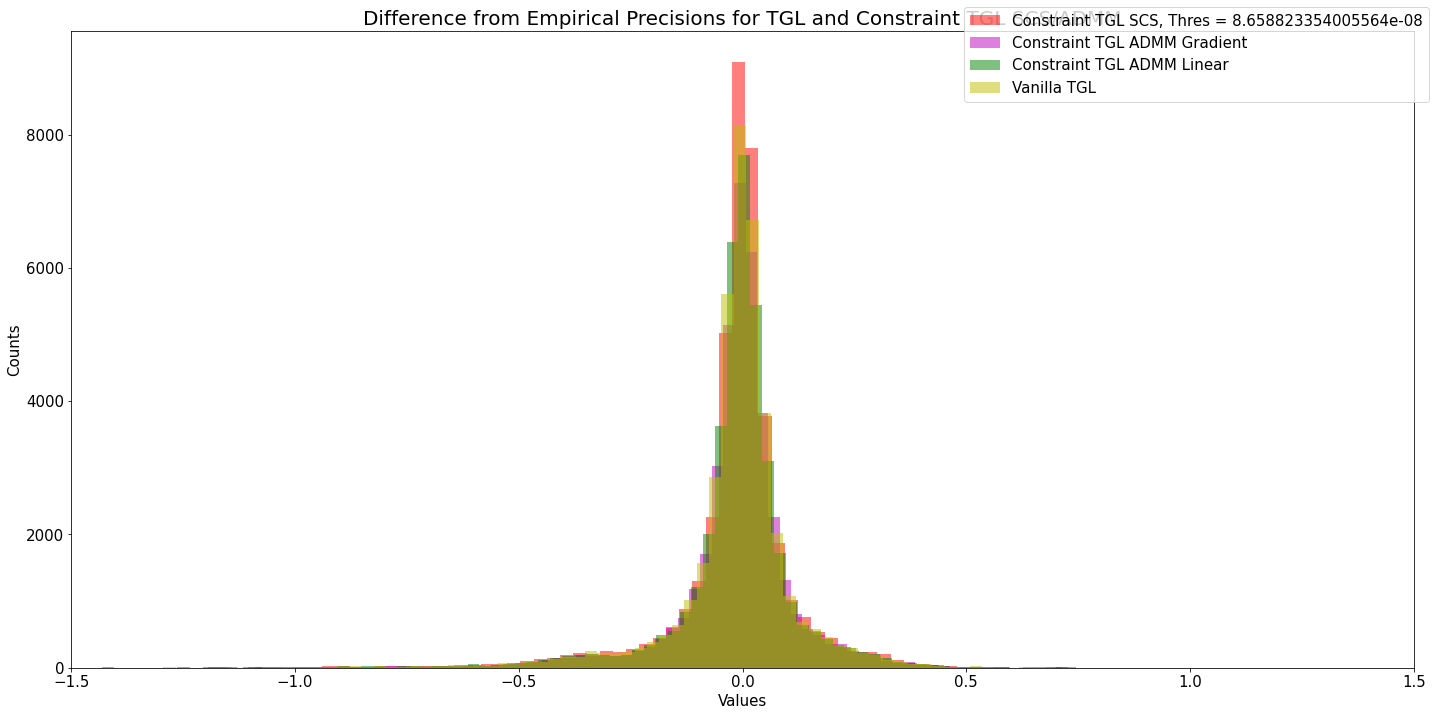

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    diff = (pre[i] -  tgl.emp_inv).flatten()
    ax.hist(diff, bins=100, color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}'.format(i))
# for i in [2.]:    
#     diff = (res[i][3] -  pre_cvx).flatten()
#     ax.hist(diff, bins=50, color='g', alpha=0.2,
#             label=r'Constraint TGL ADMM CVX, Div = {}'.format(i))
diff = (pre_grad -  tgl.emp_inv).flatten()
ax.hist(diff, bins=100, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient')
diff = (pre_tp -  tgl.emp_inv).flatten()
ax.hist(diff, bins=100, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear')
diff = (pre_ -  tgl.emp_inv).flatten()
ax.hist(diff, bins=100, color='y', alpha=0.5, 
        label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Values', fontsize=15)
# major_loc = MultipleLocator(base=0.05)
# ax.xaxis.set_major_locator(major_loc)
ax.set_xlim((-1.5, 1.5))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(r'Difference from Empirical Precisions for TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('pre_emp_diff_hist_{}_{}_taylor.pdf'.format(dim_X, dim_fac))

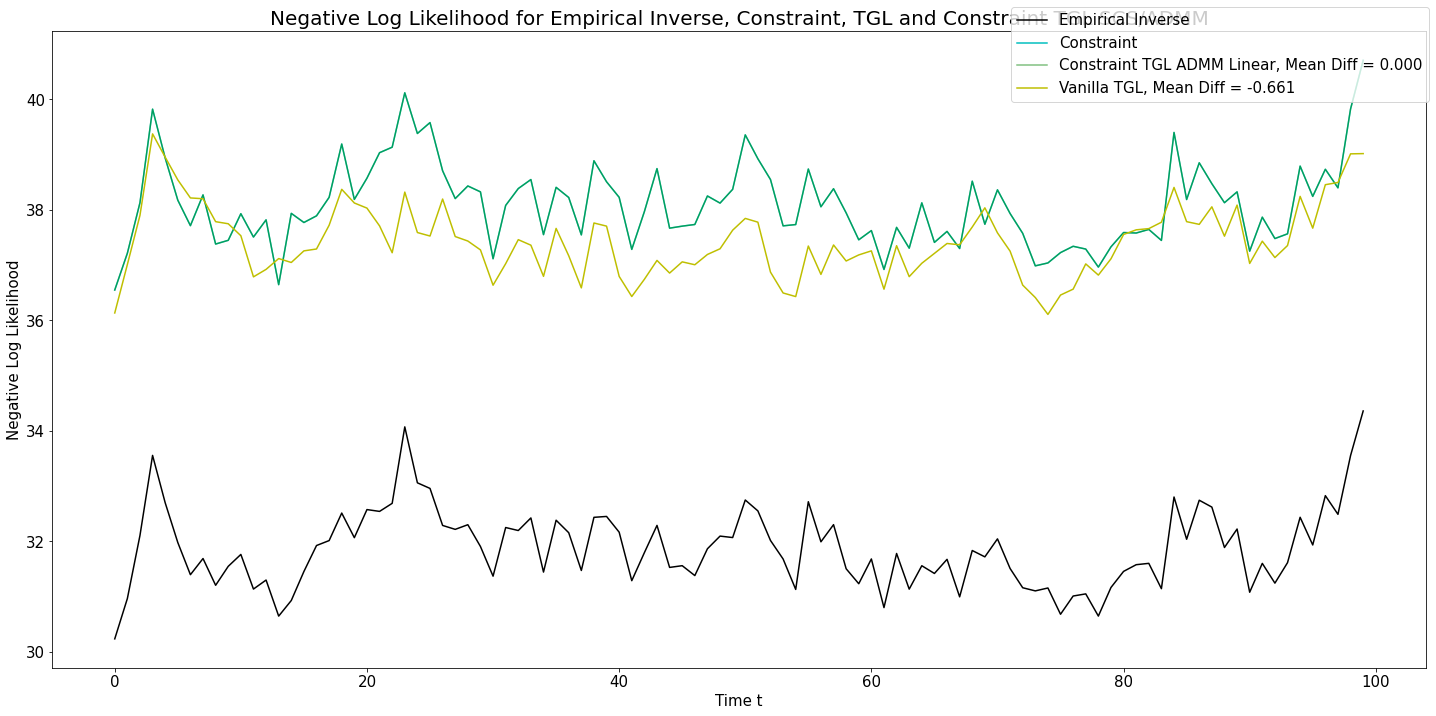

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), res[1][0], color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), res[1][1], color='c', label=r'Constraint')
# for i in [1e-2]:
# # for i in [1e-2, 1e-3, 1e-4]:
#     mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
# #     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
#             label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
#     color_index += 1
# # for i in [2.]:    
# #     mean_diff = np.mean(np.array(res[i][2]) - res[i][1])
# #     ax.plot(range(X_cov.shape[-1]), res[i][2], alpha=0.5, color='g',
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
# # mean_diff = np.mean(np.array(fit_score_diff) - baseline_score)
# # ax.plot(range(n_time), fit_score_diff, alpha=0.5,
# #         label=r'Constraint TGL ADMM Difference, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
# ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_) - res[1][1])
ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_like_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_like_{}_{}_scs.pdf'.format(dim_X, dim_fac))

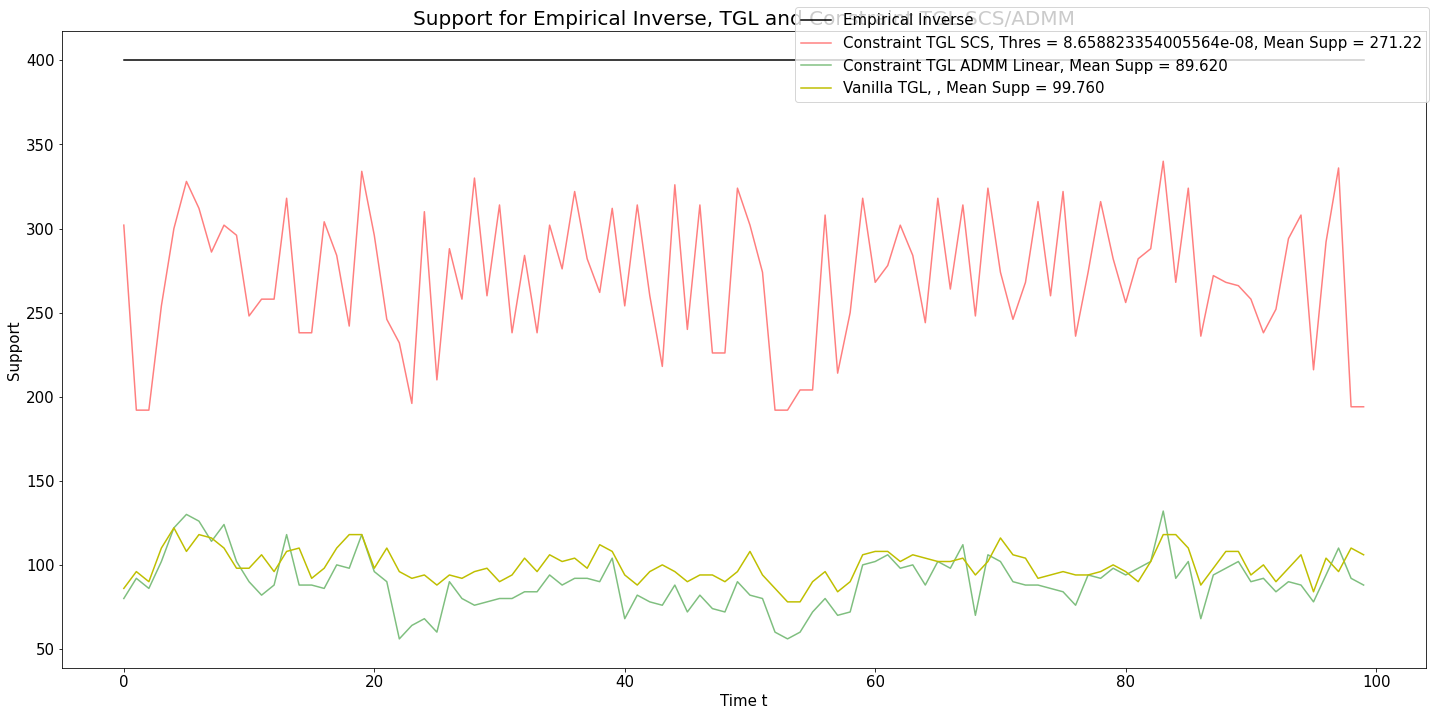

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# # for i in [2.]:    
# #     supp = [sum(sum(abs(res[i][3][t]) > 0)) for t in range(X_cov.shape[-1])]
# #     mean_supp = np.mean(supp)
# #     ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Supp = {:.3f}'.format(i, mean_supp))
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_supp_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_supp_{}_{}_scs.pdf'.format(dim_X, dim_fac))

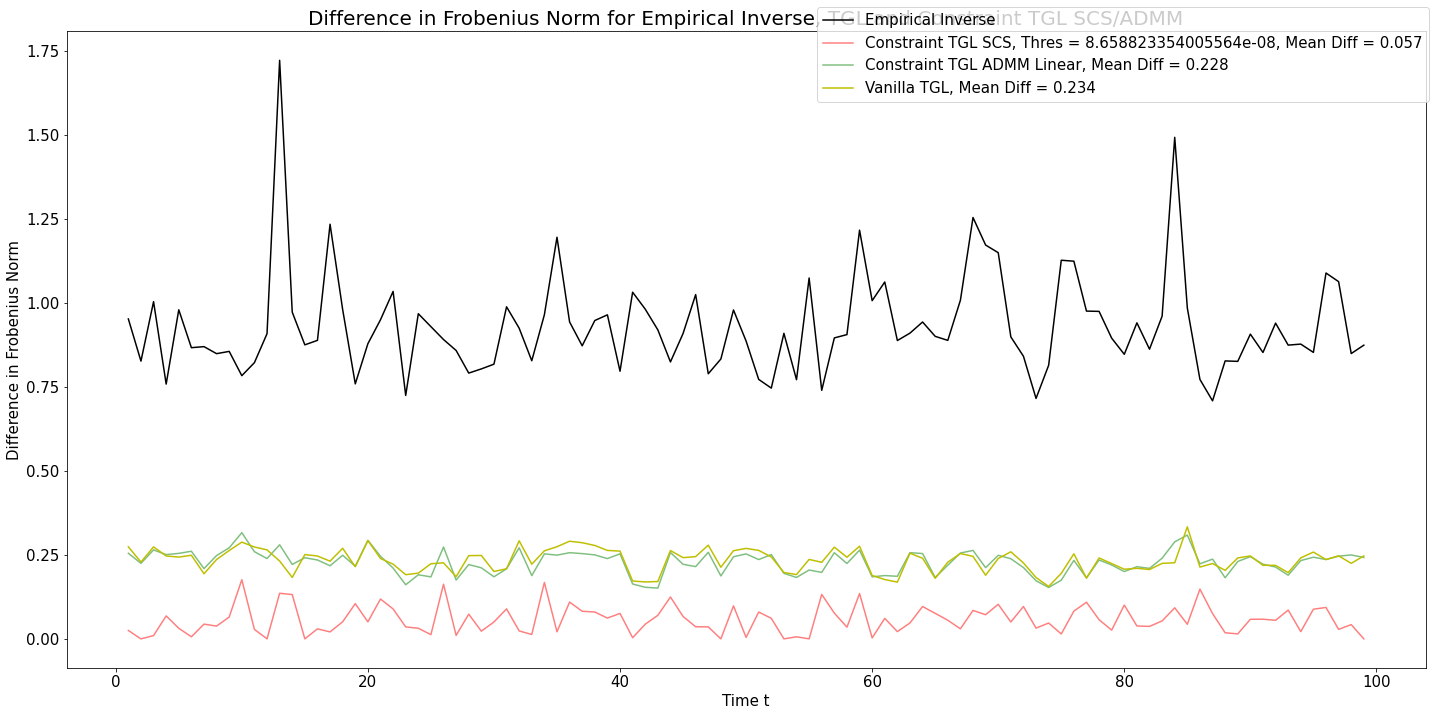

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

diff_emp = [norm(tgl.emp_inv[t] - tgl.emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
for i in [min_pre_tp]:
# for i in [1e-2, 1e-3, 1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# # for i in [2.]:    
# #     diff_cvx = [norm(res[i][3][t] - res[i][3][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# #     ax.plot(range(1, X_cov.shape[-1]), diff_cvx, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, np.mean(diff_cvx)))
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
# ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
plt.savefig('diff_fro_{}_{}_admm_taylor.pdf'.format(dim_X, dim_fac))
# plt.savefig('diff_fro_{}_{}_scs.pdf'.format(dim_X, dim_fac))